In [4]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd

# Add the parent directory of utils to the Python path
sys.path.append(os.path.join(os.getcwd(), '..'))
# from utils.utils import display_data_nice

# DAMCC


First, let us create the dataset. this requires a yaml config file in the data directory. lets use the ba.yaml as example

In [5]:
!python ../data/generate_data.py -c ../data/data_configs/ba.yaml  -p ../data/datasets -d ba

100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.81it/s]
12


This process yields a list of 6 graph sequences with 6 graphs in each sequence each of which is a networkx.Graph object. Let us now see what this generated data looks like. Let us that the first sequence out of the three.

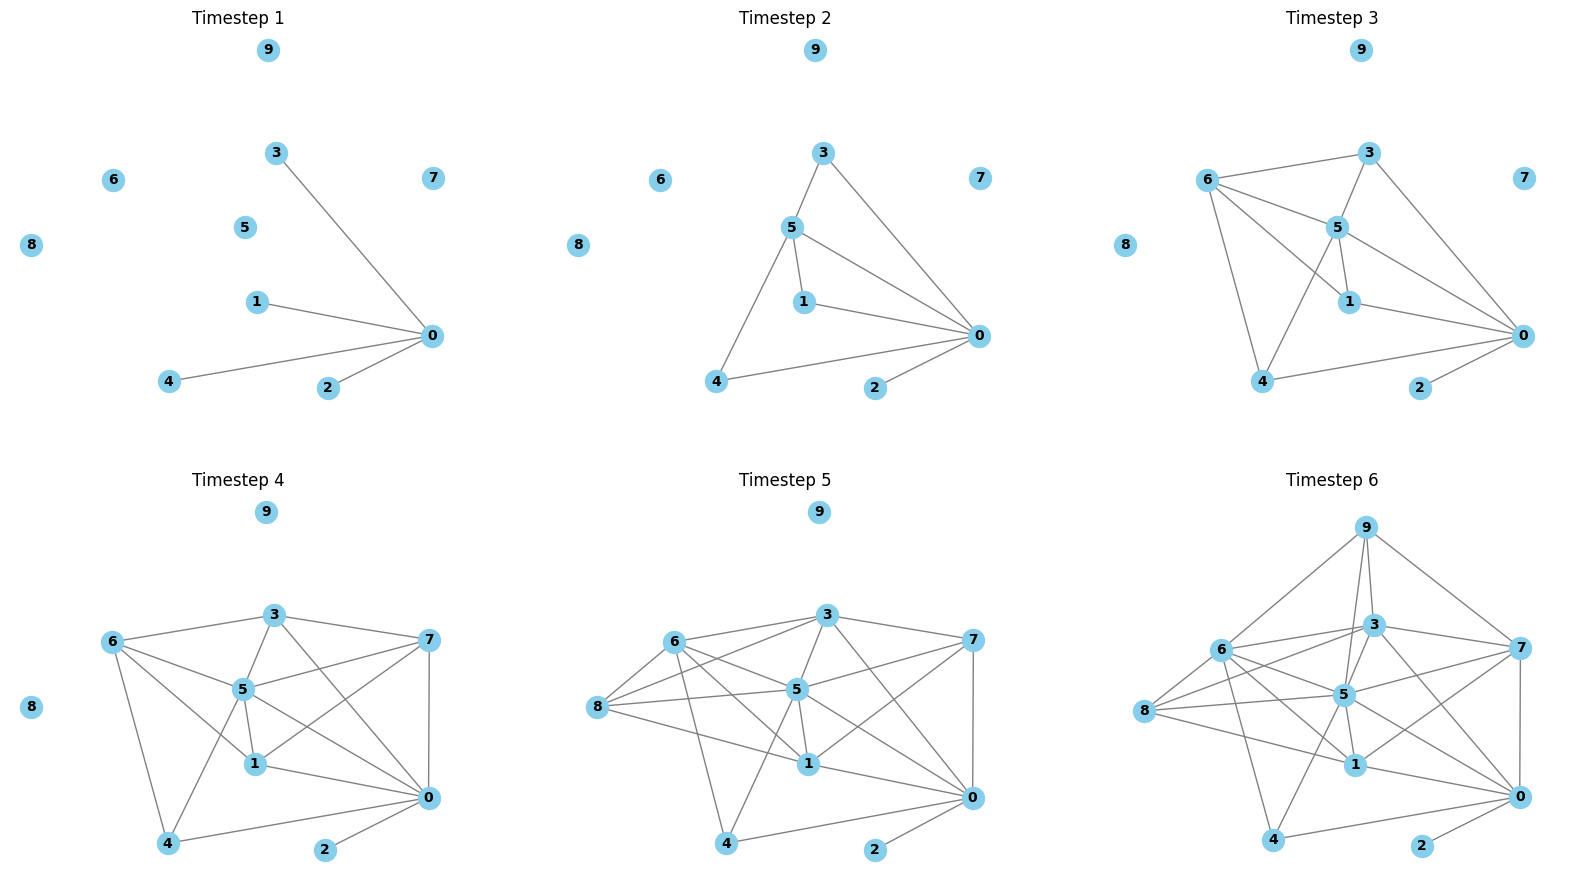

In [7]:
# set up the positions for the nodes for plotting
graph = data[0][-1]
pos = nx.spring_layout(graph, seed=4)  # positions for all nodes with a fixed seed
pos[2]= [0.1, -0.5]

# Plot the first graph in the data list
fig, axes = plt.subplots(2, len(data[0]) // 2, figsize=(20, 11))
axes = axes.flatten()  # Flatten the 2D array of axes
for i, graph in enumerate(data[0]):
    ax = axes[i]
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=250, edge_color='gray', font_size=10, font_color='black', font_weight='bold', ax=ax)
    ax.set_title(f"Timestep {i+1}")
plt.show()


Then, we need to preprocess:

Note: 
The train proportion -t and validation proportion -v, (and leftover test proportion) have a big impact on training time/sampling. Leave any of them at 60% or higher at your own risk


In [8]:
!python ../data/preprocess_data.py -d ../data/datasets/ba.pkl -s ../data/processed_datasets/ba/graph_data/ -t 0.5 -v 0.5 -r False

Randomizing
Number of Training TS:  3
Number of Val TS:  3
Number of Test TS:  6
TS length (T):  6
Saving Graphs
6
6
6
Computing Deltas
Converting to networkx format
100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 635.57it/s]
Setting attributes.
100%|███████████████████████████████████████| 15/15 [00:00<00:00, 118260.45it/s]
Computing Deltas
Converting to networkx format
100%|█████████████████████████████████████████| 15/15 [00:00<00:00, 3201.76it/s]
Setting attributes.
100%|███████████████████████████████████████| 15/15 [00:00<00:00, 144299.45it/s]


You should now have the following files in the data directory:
ba_test_graphs_raw.pkl  ba_train_graphs.pkl  ba_train_graphs_raw.pkl  ba_val_graphs.pkl  ba_val_graphs_raw.pkl. Let us now see processed format of our data:

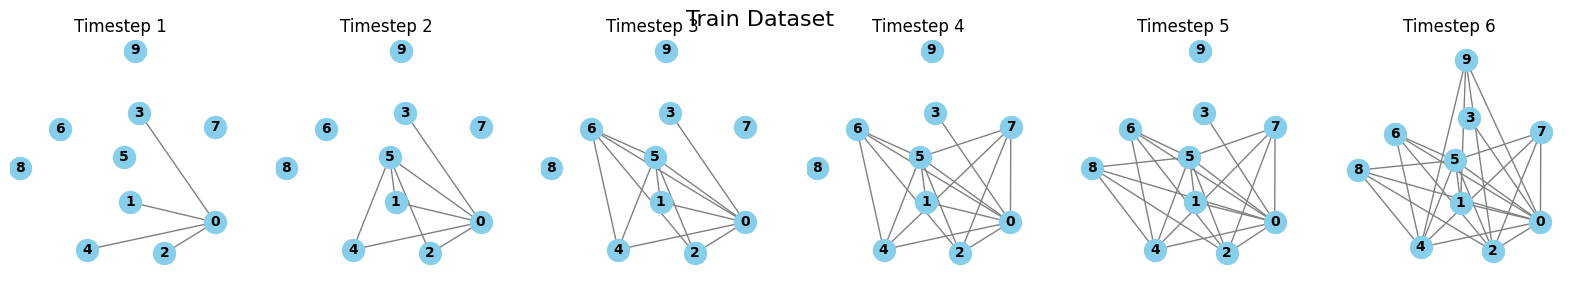

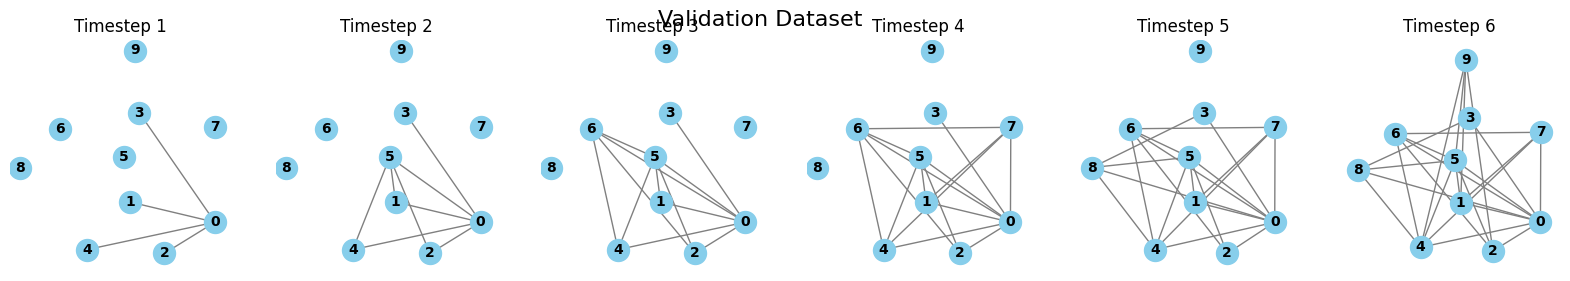

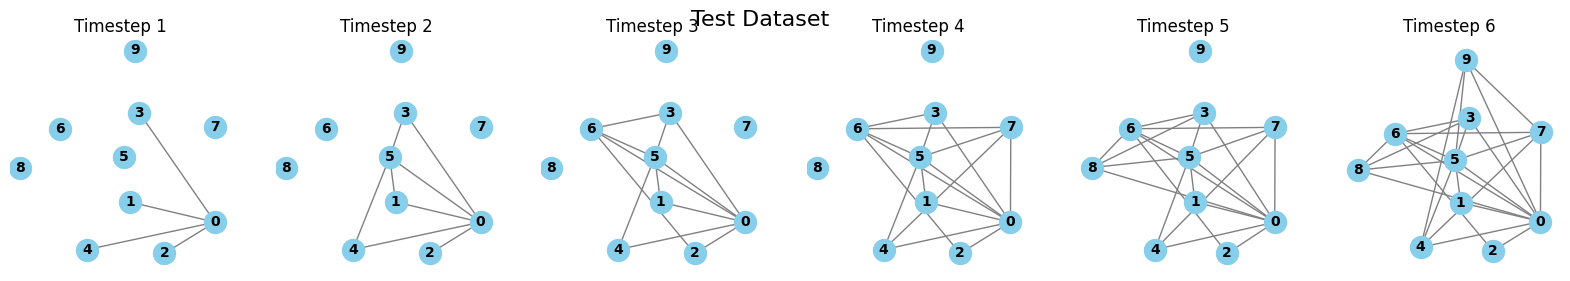

In [9]:
# the non-raw datasets are for the damnets model
with open('../data/processed_datasets/ba/graph_data/ba_train_graphs_raw.pkl', 'rb') as file:
    train_data = pickle.load(file)
with open('../data/processed_datasets/ba/graph_data/ba_val_graphs_raw.pkl', 'rb') as file:
    val_data = pickle.load(file)
with open('../data/processed_datasets/ba/graph_data/ba_test_graphs_raw.pkl', 'rb') as file:
    test_data = pickle.load(file)

# Let us plot a series from each dataset
datasets = [train_data, val_data, test_data]
dataset_names = ['Train', 'Validation', 'Test']
for dataset, name in zip(datasets, dataset_names):
    fig, axes = plt.subplots(1, len(dataset[0]), figsize=(20, 3))
    axes = axes.flatten()  # Flatten the 2D array of axes
    for i, graph in enumerate(dataset[0]):
        ax = axes[i]
        nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=250, edge_color='gray', font_size=10, font_color='black', font_weight='bold', ax=ax)
        ax.set_title(f"Timestep {i+1}")
    fig.suptitle(f"{name} Dataset", fontsize=16)
    plt.show()

Let us now convert these graphs to CC format:

In [10]:
!python ../utils/process_graph_to_cc.py -i ../data/processed_datasets/ba/graph_data/ba_train_graphs_raw.pkl -o ../data/processed_datasets/ba/CC_data
!python ../utils/process_graph_to_cc.py -i ../data/processed_datasets/ba/graph_data/ba_val_graphs_raw.pkl -o ../data/processed_datasets/ba/CC_data
!python ../utils/process_graph_to_cc.py -i ../data/processed_datasets/ba/graph_data/ba_test_graphs_raw.pkl -o ../data/processed_datasets/ba/CC_data

Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 352.65it/s]
Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 530.64it/s]
Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 518.63it/s]
Setting x_0
100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 35645.64it/s]
Setting x_0
100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 73369.75it/s]
Setting x_0
100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 4651.72it/s]
Data saved to ../data/processed_datasets/ba/CC_data/ba_train_ccs.pkl
Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 353.72it/s]
Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 568.06it/s]
Converting graphs to ccs
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 520.69it/s]
Setting x_0
100%

Let us now see what this CC data look like:

In [11]:
from utils.process_graph_to_cc import CCDataset
# CCDataset()

with open('../data/processed_datasets/ba/CC_data/ba_train_ccs.pkl', 'rb') as cc_data:
    cc = pickle.load(cc_data)


cc.complexes[2].incidence_matrix(1, 2, index=False).shape


(12, 3)


time to train the model:

In [12]:
!python ../run_damcc.py --train --data_name ba --train_file ../data/processed_datasets/ba/CC_data/ba_train_ccs.pkl --val_file ../data/processed_datasets/ba/CC_data/ba_val_ccs.pkl --save_dir ../experiments --max_epochs 2 --lr 0.001

Using device: cpu
  0%|                                                    | 0/15 [00:00<?, ?it/s]At Epoch 1:
/opt/anaconda3/envs/damcc_eval/lib/python3.11/site-packages/topomodelx/nn/combinatorial/hmc_layer.py:680: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  A_p = torch.sparse.mm(A_p, neighborhood)
generating rows

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 32.07it/s]
generating rows

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 231.30it/s]
RETURNING INCIDENCE MATRIX
incidence matrix size was:  4
new size:  8
generating rows

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 59.12it/s]
generating rows

100%|████████████████████████████████████████████| 1/1 [

We now test

In [13]:
!python ../run_damcc.py --test --data_name ba --test_file ../data/processed_datasets/ba/CC_data/ba_test_ccs.pkl --test_graphs_file ../data/processed_datasets/ba/graph_data/ba_test_graphs_raw.pkl --model_path ../experiments/last_experiment/best_val_model.pth --save_dir ../experiments/last_experiment/

Using device: cpu
/opt/anaconda3/envs/damcc_eval/lib/python3.11/site-packages/topomodelx/nn/combinatorial/hmc_layer.py:680: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  A_p = torch.sparse.mm(A_p, neighborhood)
generating rows
100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 139.02it/s]
generating rows
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 70.51it/s]
RETURNING INCIDENCE MATRIX
incidence matrix size was:  4
new size:  8
generating rows
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 522.13it/s]
generating rows
100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 668.84it/s]
RETURNING INCIDENCE MATRIX
incidence matrix size was:  1
new size:  2
g

Let us see what the Sampled graphs look like:

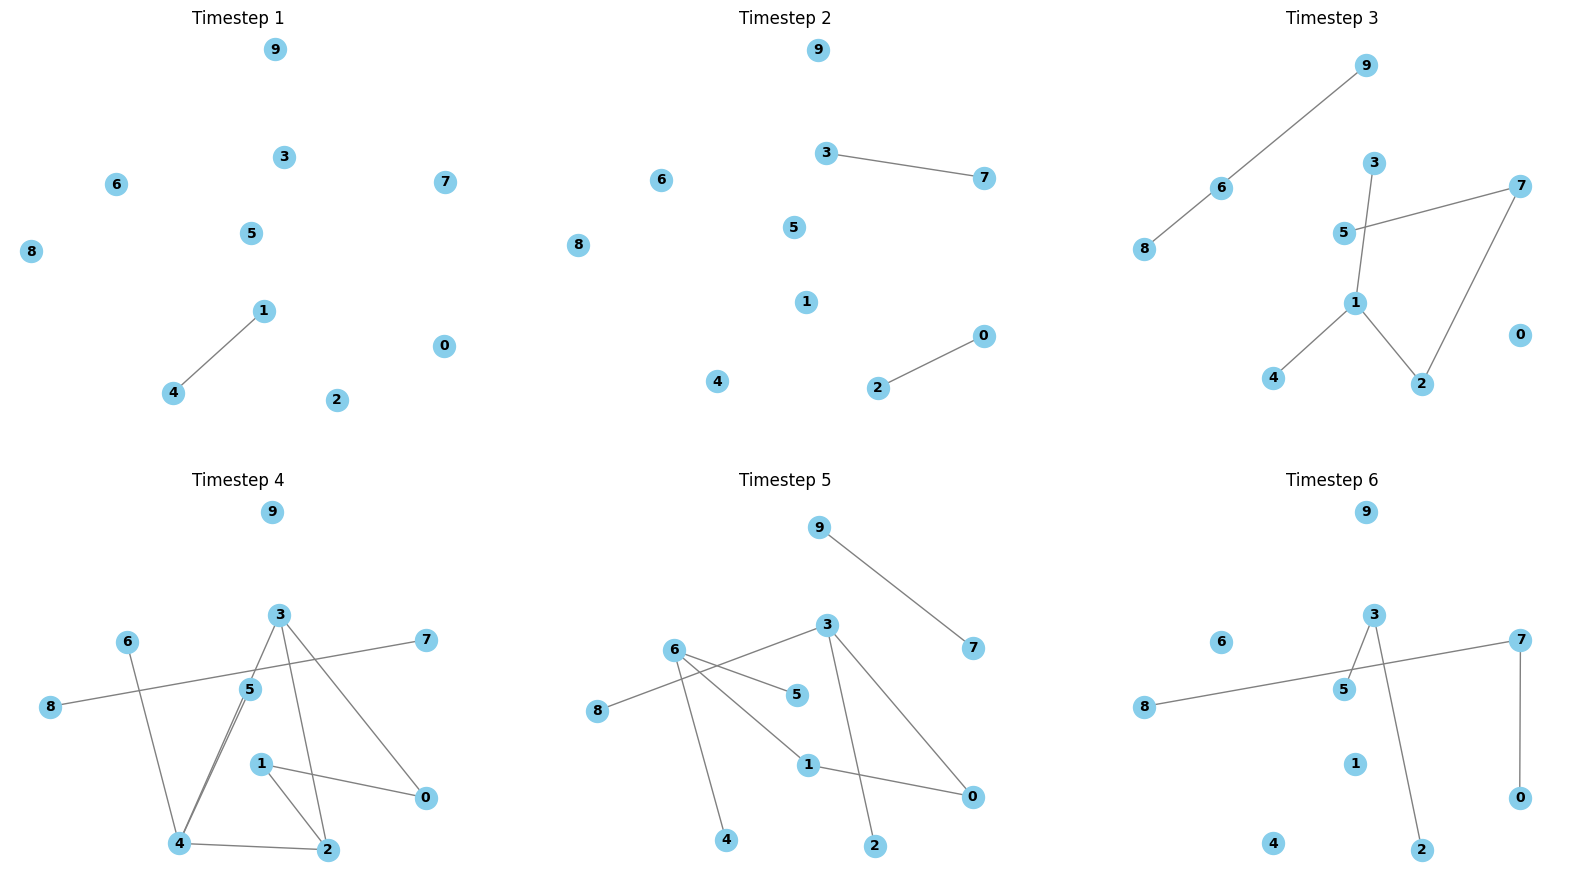

In [14]:
with open('../experiments/last_experiment/test/sampled_graphs.pkl', 'rb') as file:
    generated_data = pickle.load(file)
# Plot the first graph in the data list
fig, axes = plt.subplots(2, len(data[0]) // 2, figsize=(20, 11))
axes = axes.flatten()  # Flatten the 2D array of axes
for i, graph in enumerate(generated_data[0]):
    ax = axes[i]
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=250, edge_color='gray', font_size=10, font_color='black', font_weight='bold', ax=ax)
    ax.set_title(f"Timestep {i+1}")
plt.show()


and evaluate:

In [15]:
!python ../eval.py \
    --sampled_path ../experiments/last_experiment/test/sampled_graphs.pkl \
    --test_path ../data/processed_datasets/ba/graph_data/ba_test_graphs_raw.pkl \
    --dataset_name ba \
    --model_name damcc \
    --output_dir ../eval

Computing statistics for model damcc
Computing Density
Computing Clustering
Computing Transitivity
Computing Assortativity
Computing Closeness
Computing statistics for model Test
Computing Density
Computing Clustering
Computing Transitivity
Computing Assortativity
Computing Closeness
Computing Local MMDs
100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 127.90it/s]
------ Sum MMDs ------
damcc  Degree_MMD        1.206006
       Clustering_MMD    4.457394
       Spectral_MMD      0.707770
       Trans_MMD         1.804275
       Assort_MMD        1.025483
       CC_MMD            0.708898
dtype: float64


In [16]:
from IPython.display import Image

# Display the image
Image(filename='../eval/damcc_network_statistics.jpg', width=2000, height=300)

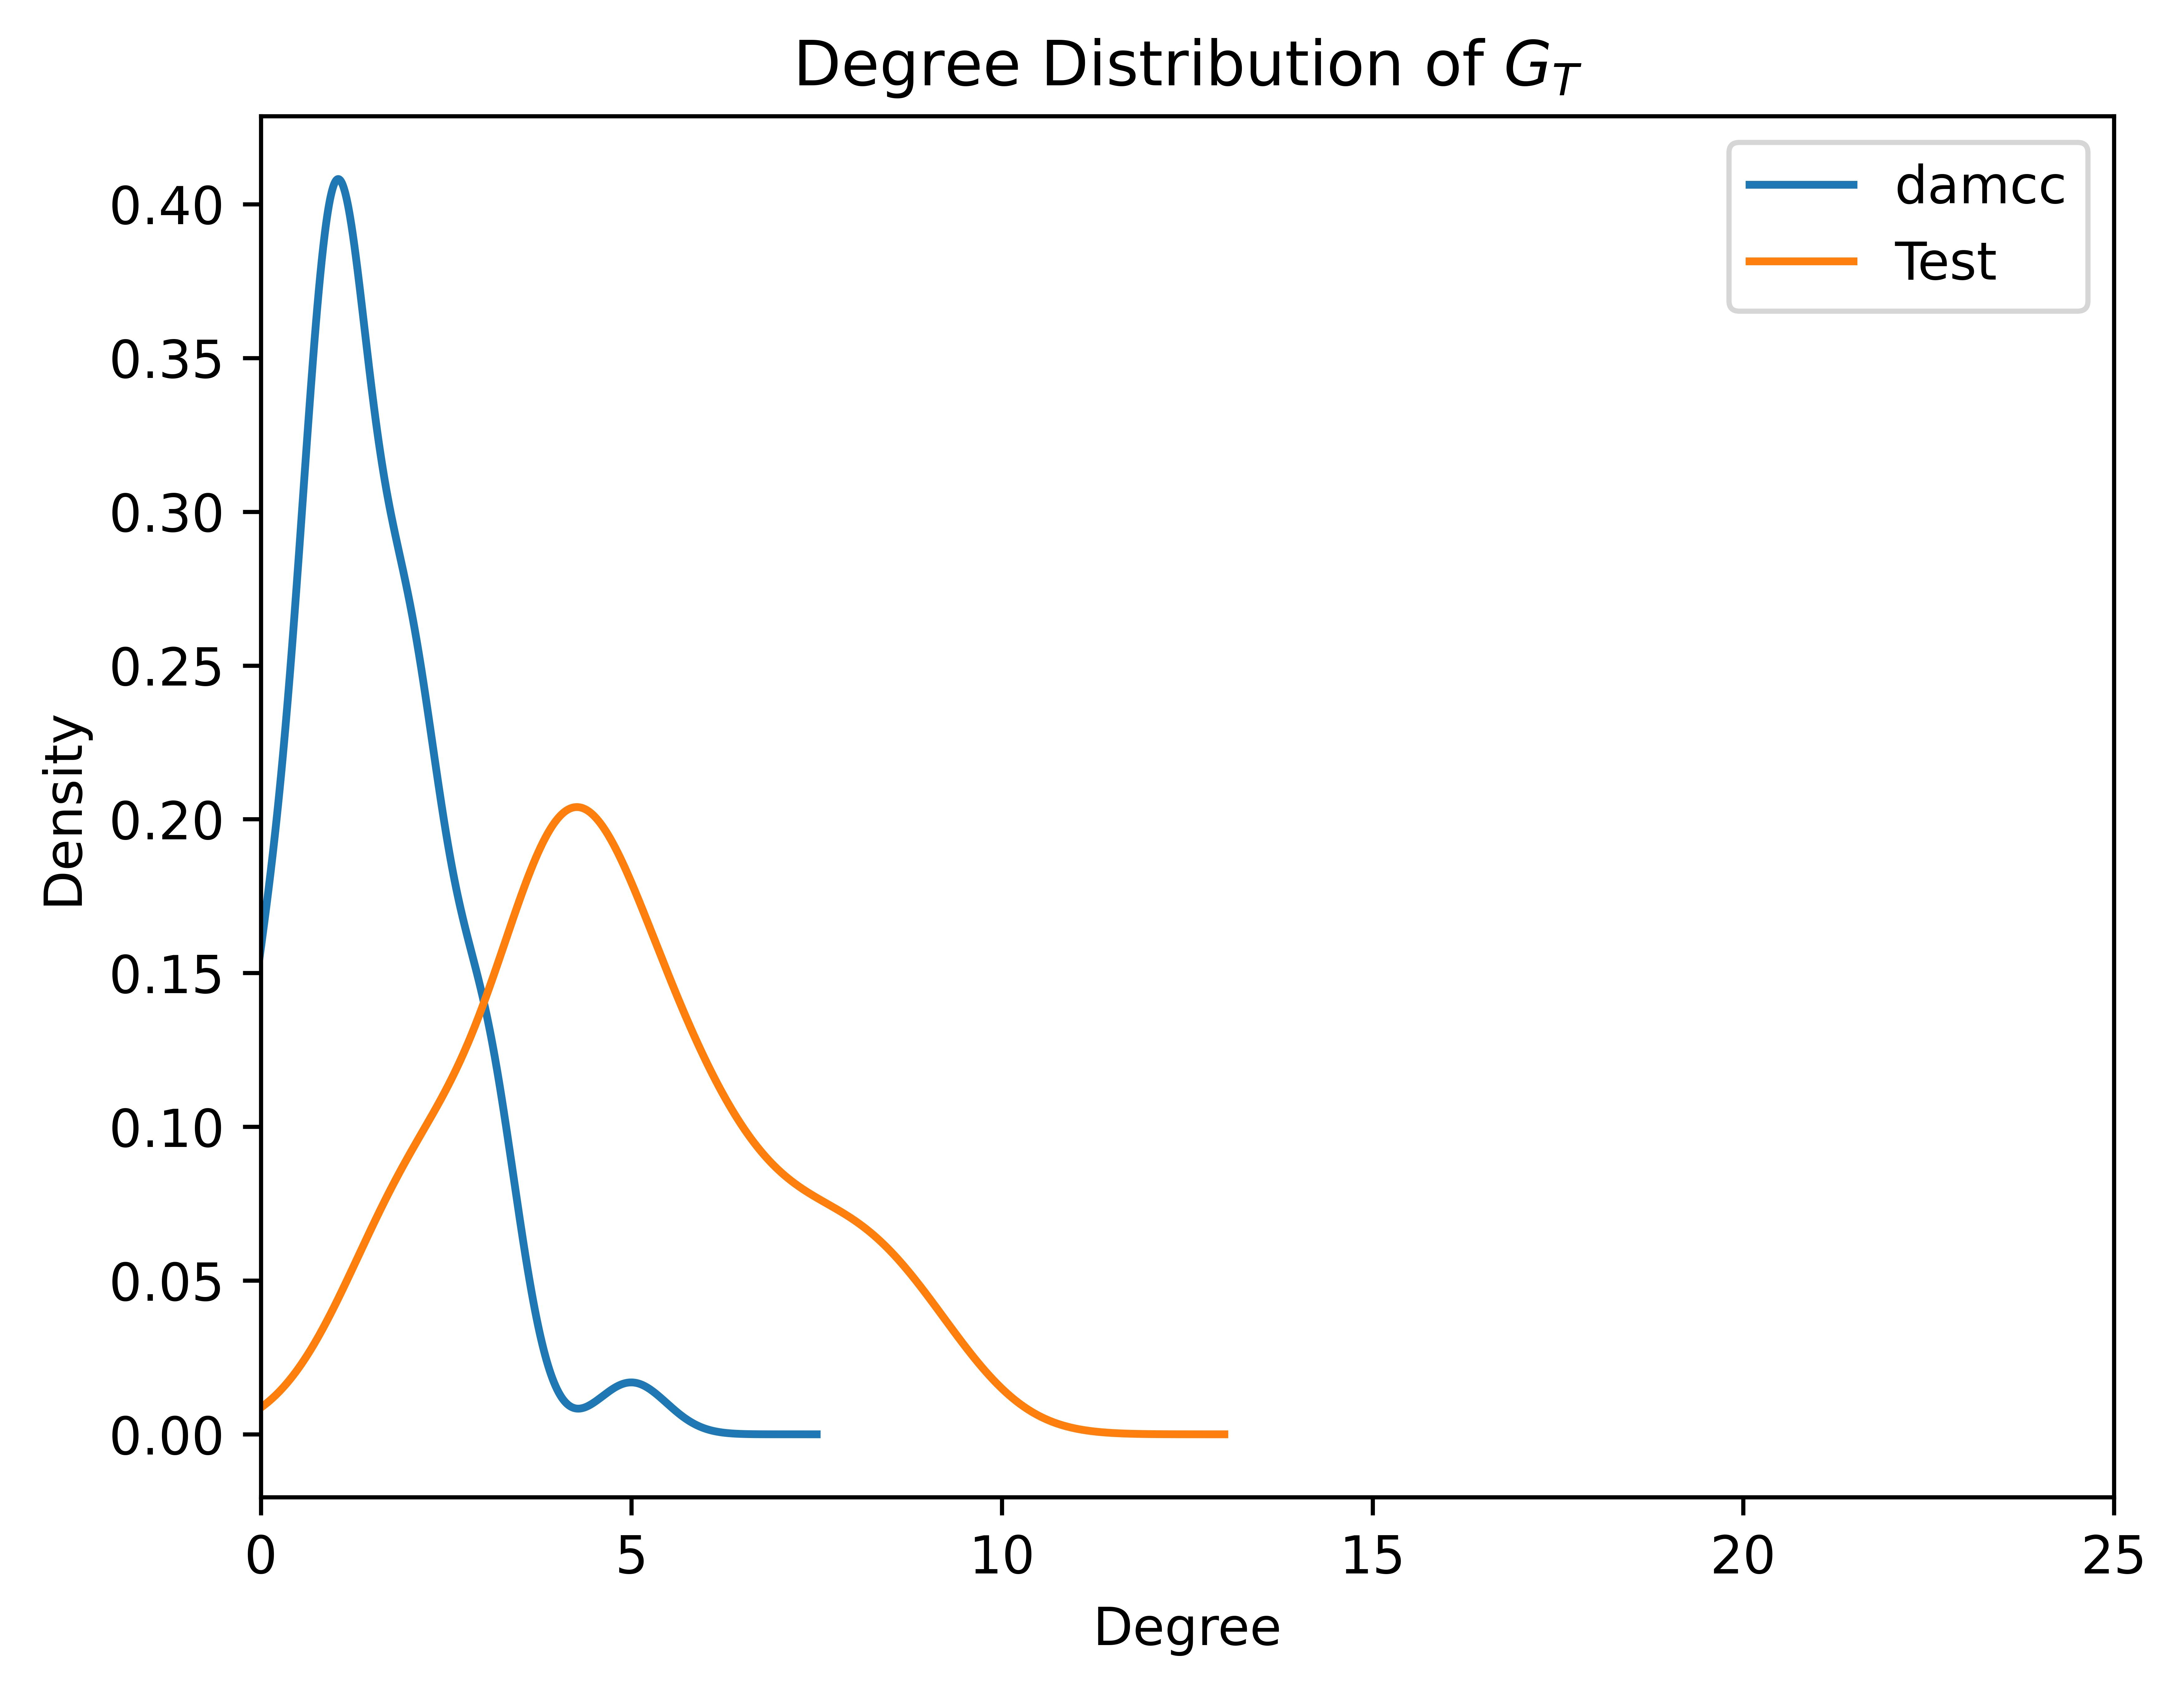

In [17]:
Image(filename='../eval/damcc_ba_degree.jpg', width=800)
